In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans


pd.options.mode.chained_assignment = None  # default='warn'

/var/folders/bc/ynvgg9rn14v5sl_jcp8x8_s40000gn/T/ipykernel_13719/2551545956.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Treating missing data


In [34]:
# Load data from a CSV file
#data = pd.read_csv('./data/HR_data.csv', index_col=0)
# Read from zip file
import zipfile
 
# open zipped dataset
with zipfile.ZipFile("data.zip") as z:
   # open the csv file in the dataset
   with z.open("data/HR_data.csv") as f:
       
      # read the dataset
      data = pd.read_csv(f, index_col=0)

num_cols = data.columns[:51] 
cat_cols = data.columns[51:]

missing_data = data.isnull().sum()
missing_data = missing_data[missing_data > 0]
missing_data.sort_values(inplace=True)

missing_rows = data.isnull().any(axis=1)
missing_cols = missing_data.index

data[missing_rows][missing_cols]

,EDA_TD_P_RT,EDA_TD_P_ReT,attentive,afraid,active,inspired,determined
104,2.321429,1.892857,NaN,NaN,NaN,2.0,NaN
120,1.968750,2.703125,2.0,1.0,2.0,2.0,NaN
122,3.387500,2.367647,3.0,1.0,2.0,NaN,3.0
125,2.108696,1.911765,3.0,4.0,2.0,NaN,2.0
272,NaN,NaN,3.0,1.0,3.0,2.0,3.0


5 out of 302 rows have missing data, mainly in the questionaire answers. Instead of dropping the rows, we choose to impute the values by their mean withing the corresponding Cohort, Round, Phase and the Puzzler type. For the questionnaire values, the mean is rounded to the neares integer.

In [35]:
# Calculate mean of the column within the same Round, Phase, Puzzler and Cohort
means_for_missing = data.groupby(['Round', 'Phase', 'Puzzler', 'Cohort']).mean().reset_index()

# Replace missing values
for index, row in data.iterrows():
    if row.isnull().any():
        mean_row = means_for_missing[(means_for_missing['Round'] == row['Round']) 
                                     & (means_for_missing['Phase'] == row['Phase']) 
                                     & (means_for_missing['Puzzler'] == row['Puzzler']) 
                                     & (means_for_missing['Cohort'] == row['Cohort'])]
        
        # only replace the values that are missing
        for col in row[row.isnull()].index:
            # round the questionnaire values
            if col in ['attentive', 'afraid', 'active', 'inspired', 'determined']:
                data.at[index, col] = np.round(mean_row[col].values[0])
            else:
                data.at[index, col] = mean_row[col].values[0]

# Check that it works as expected
data[missing_rows][missing_cols]

,EDA_TD_P_RT,EDA_TD_P_ReT,attentive,afraid,active,inspired,determined
104,2.321429,1.892857,3.0,1.0,2.0,2.0,3.0
120,1.968750,2.703125,2.0,1.0,2.0,2.0,2.0
122,3.387500,2.367647,3.0,1.0,2.0,2.0,3.0
125,2.108696,1.911765,3.0,4.0,2.0,2.0,2.0
272,2.557692,2.409091,3.0,1.0,3.0,2.0,3.0


## Prepare and standardize data

In [44]:
from sklearn.preprocessing import StandardScaler

# Standardize
def standardize(X):
    X[num_cols] = (X[num_cols] - X[num_cols].mean()) / X[num_cols].std()
    return X
# Standardize
# def standardize(X):
#     #X = (X - X.mean()) / X.std()
#     X = StandardScaler().fit_transform(X)
    return X

## Simple Feature Selection
* Within pairs of features with high correlation, remove one of the features, in order to prevent multicollinarity
* With a threshold of 0.75, it results in 25 features

In [25]:
data_num = data[num_cols]
correlation_matrix = data_num.corr().abs()

# Select upper triangle of correlation matrix
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]

data_filtered = data_num.drop(columns=to_drop)
print("Selectec features: ", data_filtered.columns)
print("Number of features selected: ", len(data_filtered.columns))

Selectec features:  Index(['HR_TD_Mean', 'HR_TD_std', 'HR_TD_Kurtosis', 'HR_TD_Skew',
       'HR_TD_Slope_min', 'HR_TD_Slope_max', 'HR_TD_Slope_mean',
       'TEMP_TD_Mean', 'TEMP_TD_std', 'TEMP_TD_AUC', 'TEMP_TD_Kurtosis',
       'TEMP_TD_Skew', 'TEMP_TD_Slope_min', 'TEMP_TD_Slope_max',
       'TEMP_TD_Slope_mean', 'EDA_TD_P_Mean', 'EDA_TD_P_Min',
       'EDA_TD_P_Kurtosis', 'EDA_TD_T_Mean', 'EDA_TD_T_Kurtosis',
       'EDA_TD_T_Skew', 'EDA_TD_T_Slope_mean', 'EDA_TD_P_Peaks', 'EDA_TD_P_RT',
       'EDA_TD_P_ReT'],
      dtype='object')
Number of features selected:  25


## Emotion exploration

Lets try to combine questionnaire answers into one score by subtracting the negative emotions from the positive emotions.

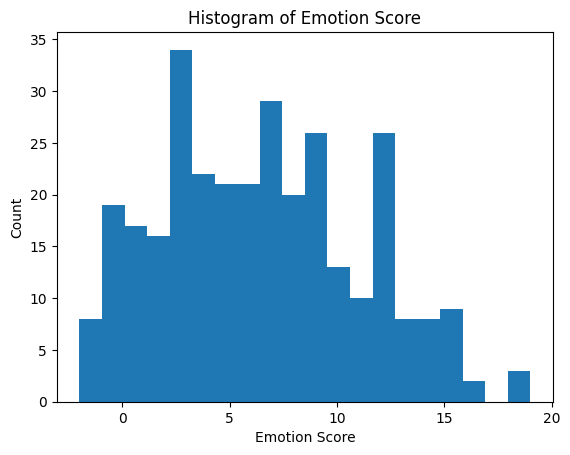

In [54]:
positive_emotions = ['active', 'alert', 'attentive', 'determined', 'inspired']
negative_emotions = ['afraid', 'ashamed', 'hostile', 'nervous', 'upset']

data['positive_score'] = data[positive_emotions].sum(axis=1)
data['negative_score'] = data[negative_emotions].sum(axis=1)
data['emotion_score'] = data['positive_score'] - data['negative_score']

plt.hist(data.emotion_score, bins=20);
plt.title('Histogram of Emotion Score')
plt.ylabel('Count')
plt.xlabel('Emotion Score')
plt.show()


However, a problem is that I-PANAS-SF is designed to measure both positive and negative affect, and it is important to consider both aspects when assessing emotional well-being. Combining the scores into one number would not provide a nuanced understanding of an individual's emotional state, as it would not distinguish between positive and negative affect. Therefore, we continue with an exploration where the negative and positive emotion resposes are summed, but kept separate.


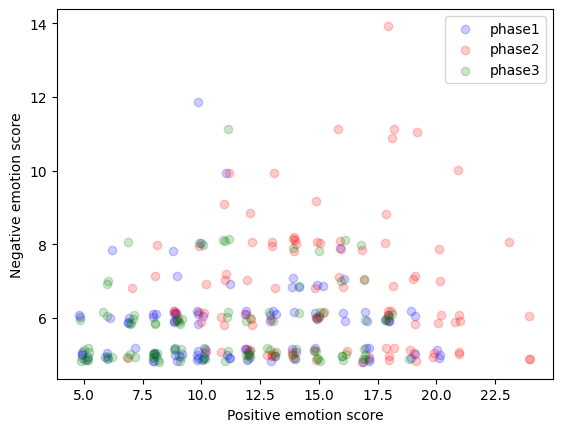

In [7]:
def jitter_points(data, jitter=0.2):
    return data + np.random.uniform(-jitter, jitter, size=len(data))

p_to_c = {'phase1': 'blue', 'phase2': 'red', 'phase3': 'green'}

for phase in sorted(data.Phase.unique()):
    plt.scatter(jitter_points(data[data.Phase == phase].positive_score),
                jitter_points(data[data.Phase == phase].negative_score),
                alpha=0.2, c=p_to_c[phase], label=phase)
plt.xlabel('Positive emotion score')
plt.ylabel('Negative emotion score')
plt.legend()
plt.show()

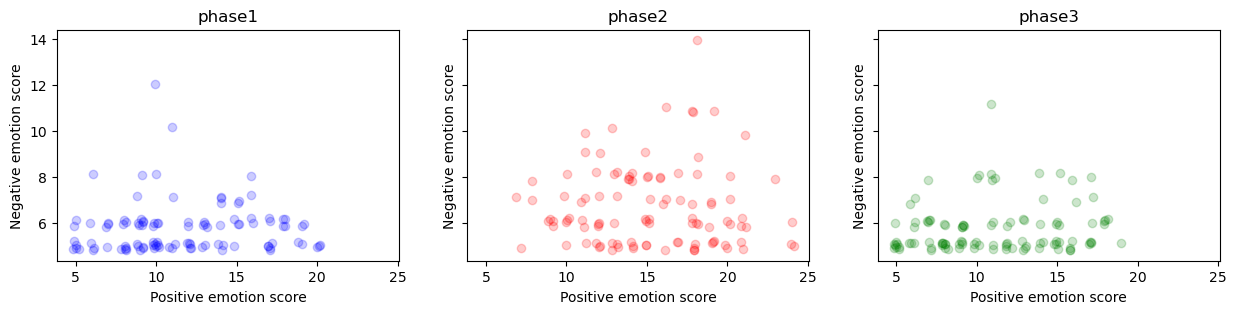

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3), sharey=True, sharex=True)

for i, phase in enumerate(['phase1', 'phase2', 'phase3']):
    axs[i].scatter(jitter_points(data[data.Phase == phase].positive_score),
                jitter_points(data[data.Phase == phase].negative_score),
                alpha=0.2, c=p_to_c[phase], label=phase)
    axs[i].set_title(phase)
    #axs[i].legend()
    axs[i].set_xlabel('Positive emotion score')
    axs[i].set_ylabel('Negative emotion score')
#plt.legend()
plt.show()

/Users/kathrinesofierasmussen/opt/anaconda3/envs/DTU/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kathrinesofierasmussen/opt/anaconda3/envs/DTU/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


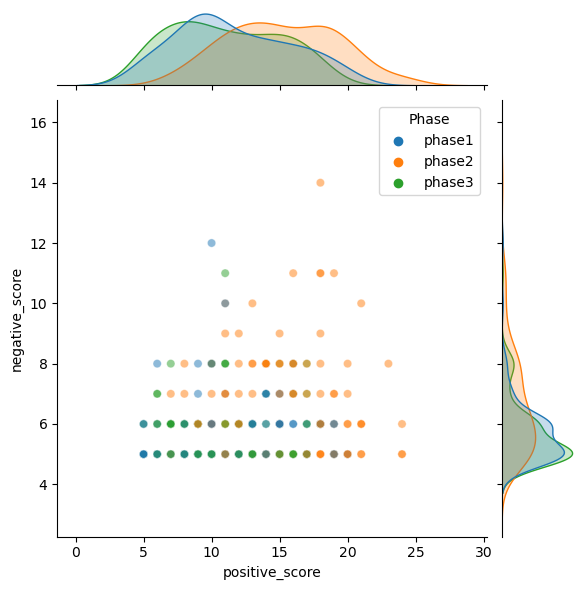

In [33]:
# alternative approach using seaborn, in this case without jitter but with KDEs on top

sns.jointplot(x='positive_score', y='negative_score', data=data, kind='scatter', alpha=0.5, hue='Phase', hue_order=['phase1', 'phase2', 'phase3'])
plt.show()

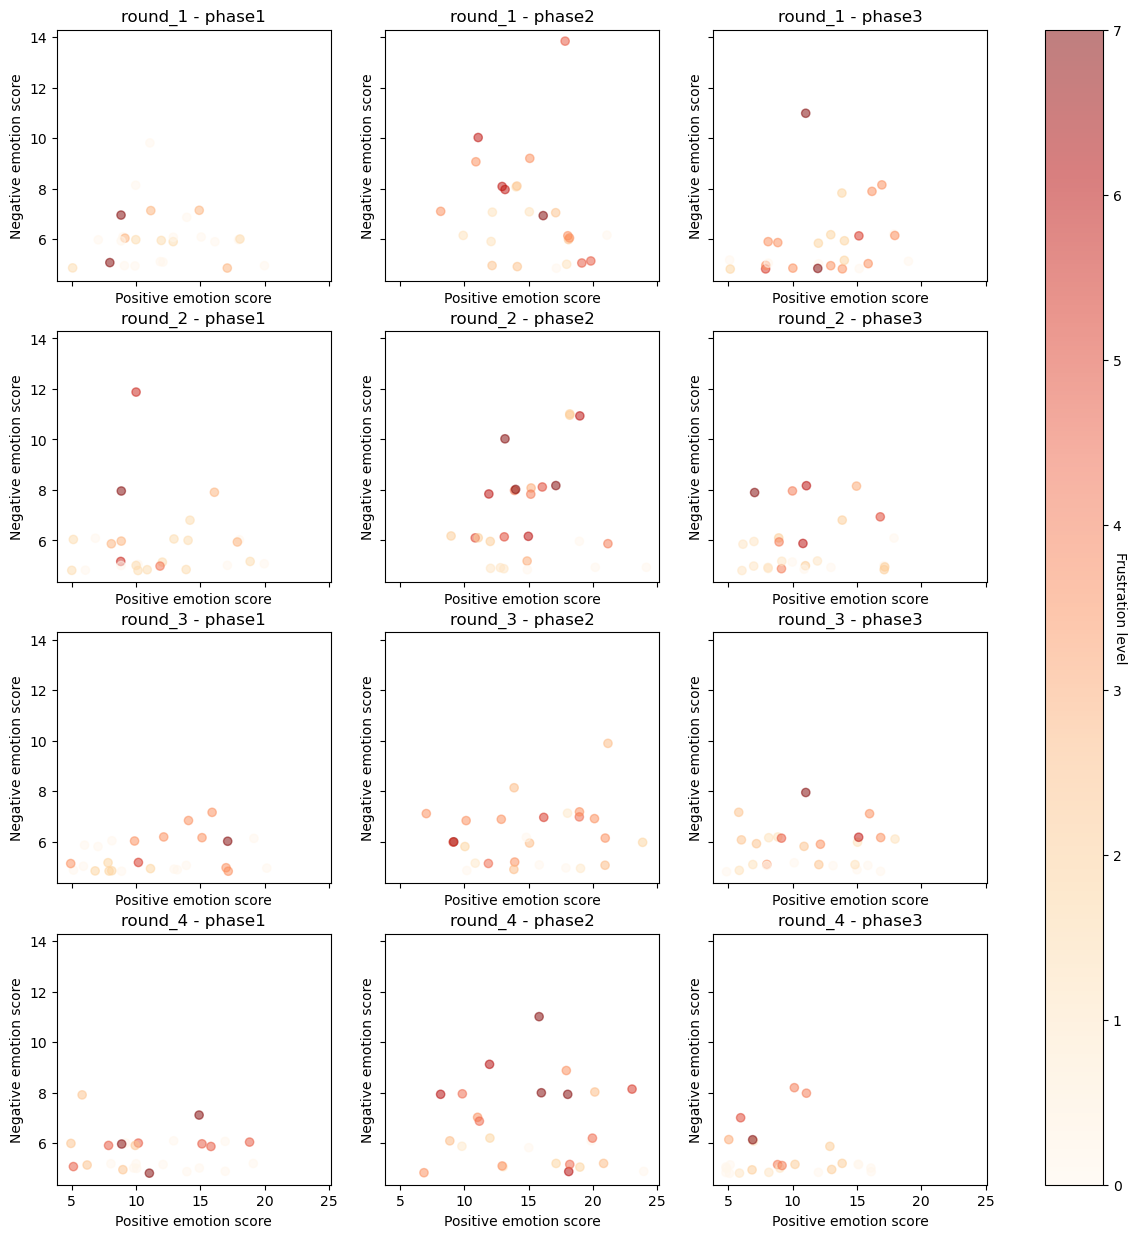

In [34]:
# emotions vs frustration level
fig, axs = plt.subplots(4, 3, figsize=(15, 15), sharey=True, sharex=True)

jitter = True
for i, round in enumerate(sorted(data.Round.unique())):
    for j, phase in enumerate(sorted(data.Phase.unique())):
        split = data[(data.Round == round) & (data.Phase == phase)]
        # X = standardize(split[num_cols])
        # kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X)
        if jitter: scat = axs[i, j].scatter(jitter_points(split.positive_score), jitter_points(split.negative_score), alpha=0.5, c=split.Frustrated, cmap='OrRd')
        else: scat = axs[i, j].scatter(split.positive_score, split.negative_score, alpha=0.5, c=split.Frustrated, cmap='OrRd')
        axs[i, j].set_title(f'{round} - {phase}')
        axs[i, j].set_xlabel('Positive emotion score')
        axs[i, j].set_ylabel('Negative emotion score')
cbar = fig.colorbar(scat, ax=axs)
cbar.ax.set_ylabel('Frustration level', rotation=270)
#plt.tight_layout()
plt.show()

Emotions throughout the rounds and phases with the color indicating the frustration level of the participants. The color is on a scale from 0 to 10, where 0 is light orange and 10 is dark red.

## Approach 1: Clustering within each round and phase and comparing to the questionnaire results

In [12]:
# The experiment was run on three separate occasions. D1_1 were completed in the winter and D1_2 and D1_3 were completed in the fall.
# D1_3 were conducted in four separate sessions; 
# D13_1 and D13_3 were completed in the morning and D13_2 and D13_4 were collected in the evening.
# For this case D1_3 has been divided into D1_3, D1_4, D1_5, D1_6
data.Cohort.value_counts()

Cohort
D1_1    96
D1_2    72
D1_4    48
D1_3    48
D1_6    24
D1_5    24
Name: count, dtype: int64

In [13]:
data.Round.value_counts()

Round
round_3    78
round_2    78
round_4    78
round_1    78
Name: count, dtype: int64

In [14]:
data.Phase.value_counts()

Phase
phase3    104
phase2    104
phase1    104
Name: count, dtype: int64

In [20]:
#cohort = 'D1_1'
round = 'round_1'
phase = 'phase1'

num_cols = data.columns[:51]
def standardize(X):
    X[num_cols] = StandardScaler().fit_transform(X[num_cols])#(X[num_cols] - X[num_cols].mean()) / X[num_cols].std()
    
    return X

#split = data[(data.Cohort == cohort) & (data.Round == round) & (data.Phase == phase)]
split = data[(data.Round == round) & (data.Phase == phase)]

In [35]:
# cluster the data with K-means clustering
from sklearn.cluster import KMeans

X = standardize(split[num_cols])

kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X)
kmeans.labels_


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1], dtype=int32)

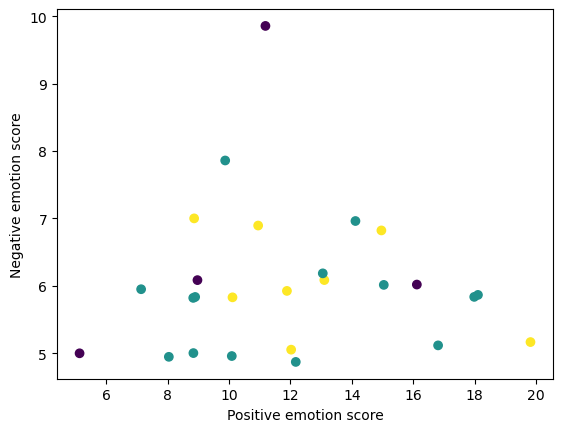

In [22]:
plt.scatter(jitter_points(split.positive_score), jitter_points(split.negative_score), c=kmeans.labels_)
plt.xlabel('Positive emotion score')
plt.ylabel('Negative emotion score')
plt.show()

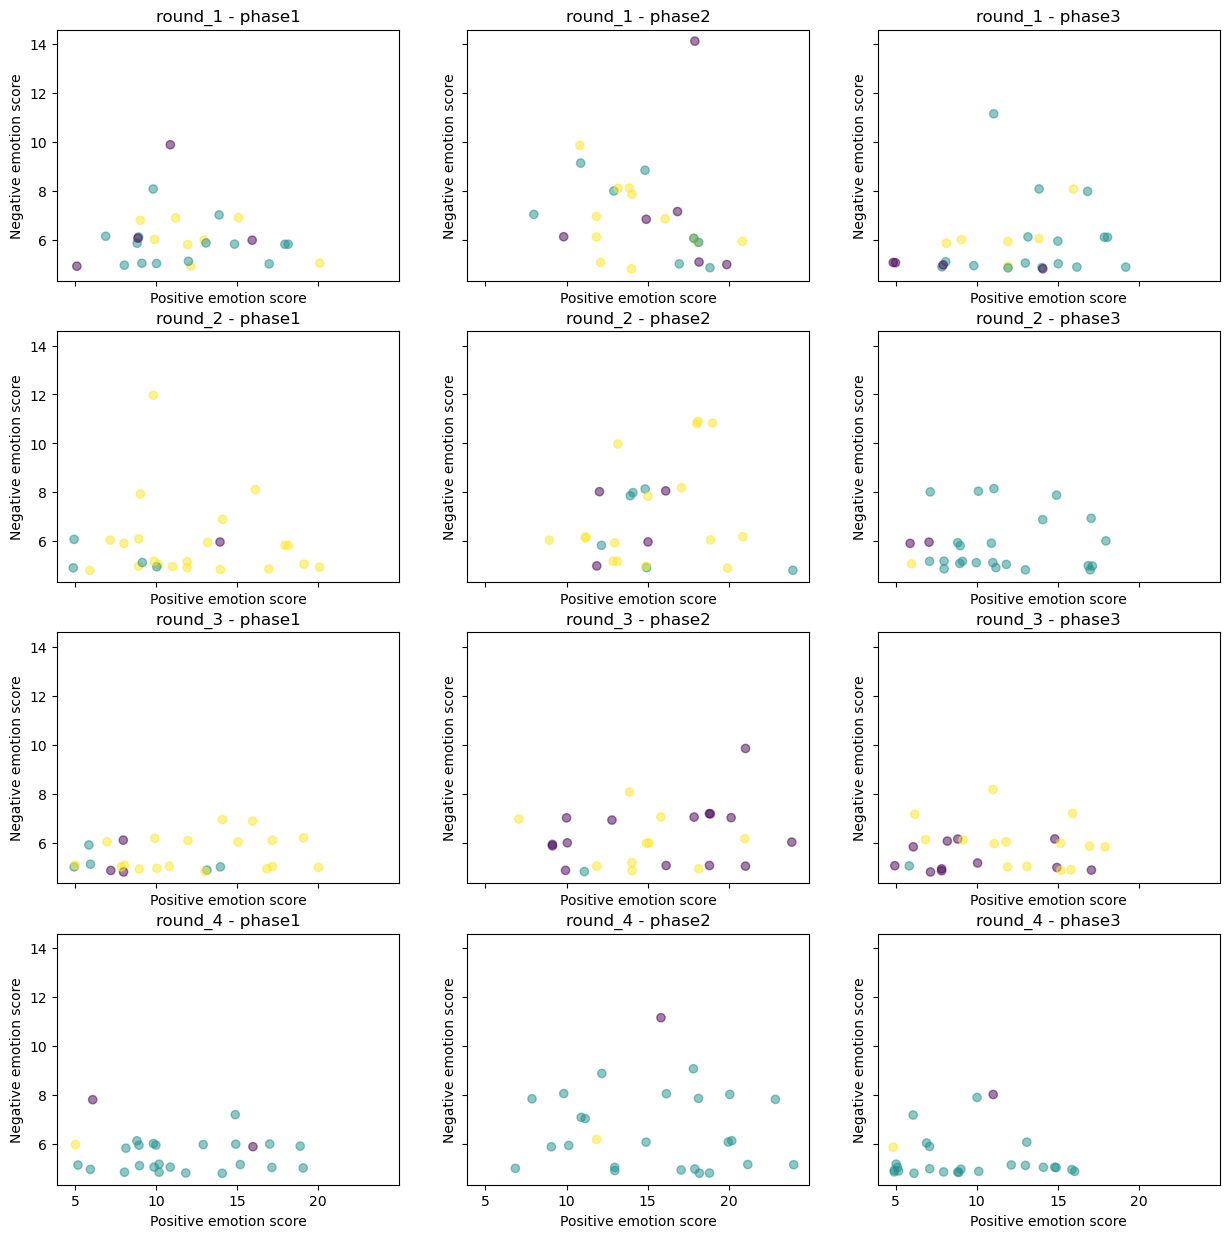

In [23]:
fig, axs = plt.subplots(4, 3, figsize=(15, 15), sharey=True, sharex=True)

for i, round in enumerate(sorted(data.Round.unique())):
    for j, phase in enumerate(sorted(data.Phase.unique())):
        split = data[(data.Round == round) & (data.Phase == phase)]
        X = standardize(split[num_cols])
        kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X)
        axs[i, j].scatter(jitter_points(split.positive_score), jitter_points(split.negative_score), c=kmeans.labels_, alpha=0.5)
        axs[i, j].set_title(f'{round} - {phase}')
        axs[i, j].set_xlabel('Positive emotion score')
        axs[i, j].set_ylabel('Negative emotion score')


## Approach 2: Clustering globally and comparing to the questionnaire results within each round/phase

In [36]:
X = standardize(data_filtered)
# Kmeans
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(X)
data['cluster'] = kmeans.labels_

In [37]:
X = standardize(data_filtered)
# apply K-medoids clustering
from sklearn_extra.cluster import KMedoids

kmedoids = KMedoids(n_clusters=4, random_state=0).fit(X)
data['cluster'] = kmedoids.labels_

ModuleNotFoundError: No module named 'sklearn_extra'

In [38]:
X = standardize(data_filtered)
# perfrom hierarchical clustering
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=3).fit(X)
data['cluster'] = agg.labels_

In [39]:
clust_part = data.groupby(['Round', 'Phase', 'cluster']).size().unstack().fillna(0)
clust_part

cluster            0    1    2
Round   Phase                 
round_1 phase1  20.0  0.0  6.0
        phase2  23.0  0.0  3.0
        phase3  17.0  1.0  8.0
round_2 phase1  17.0  3.0  6.0
        phase2  20.0  2.0  4.0
        phase3  19.0  1.0  6.0
round_3 phase1  18.0  4.0  4.0
        phase2  25.0  0.0  1.0
        phase3  20.0  1.0  5.0
round_4 phase1  17.0  4.0  5.0
        phase2  23.0  0.0  3.0
        phase3  19.0  3.0  4.0

In [40]:
positive_emotions = ['active', 'alert', 'attentive', 'determined', 'inspired']
negative_emotions = ['afraid', 'ashamed', 'hostile', 'nervous', 'upset']

/var/folders/ng/ppmp_v5s0k51l14sqbjms5x40000gn/T/ipykernel_86483/3250725572.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_clusters))


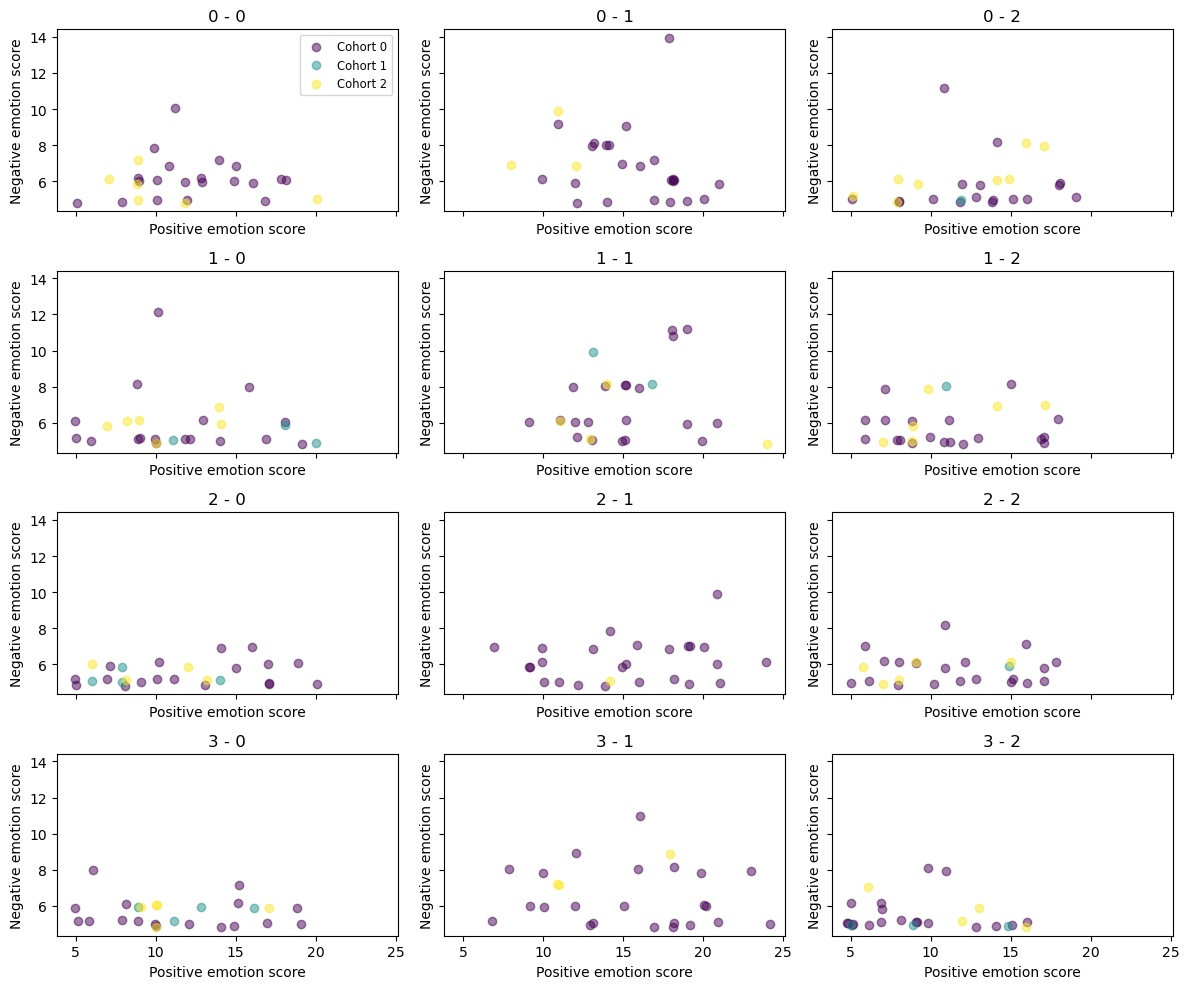

In [149]:
# Create subplots
fig, axs = plt.subplots(4, 3, figsize=(12, 10), sharey=True, sharex=True)

# Get unique rounds and phases
unique_rounds = sorted(data.Round.unique())
unique_phases = sorted(data.Phase.unique())

# Get unique clusters
unique_clusters = sorted(data.cluster.unique())

# Set colormap
colors = plt.cm.get_cmap('viridis', len(unique_clusters))

# Iterate over rounds and phases
for i, round in enumerate(unique_rounds):
    for j, phase in enumerate(unique_phases):
        split = data[(data.Round == round) & (data.Phase == phase)]
        
        # Scatter plot with color by cluster
        for cluster, color in zip(unique_clusters, colors.colors):
            cluster_data = split[split.cluster == cluster]

            axs[i, j].scatter(jitter_points(cluster_data.positive_score), 
                              jitter_points(cluster_data.negative_score),
                              color=color, alpha=0.5, label=f'Cluster {cluster}' if (i == 0 and j == 0) else None)
        
        axs[i, j].set_title(f'{round} - {phase}')
        axs[i, j].set_xlabel('Positive emotion score')
        axs[i, j].set_ylabel('Negative emotion score')

# Legend only for the first subplot
axs[0, 0].legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()

## A quick inspection of the global clusters and frustration levels

/var/folders/ng/ppmp_v5s0k51l14sqbjms5x40000gn/T/ipykernel_86483/3901944579.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_clusters))


IndexError: index 3 is out of bounds for axis 1 with size 3

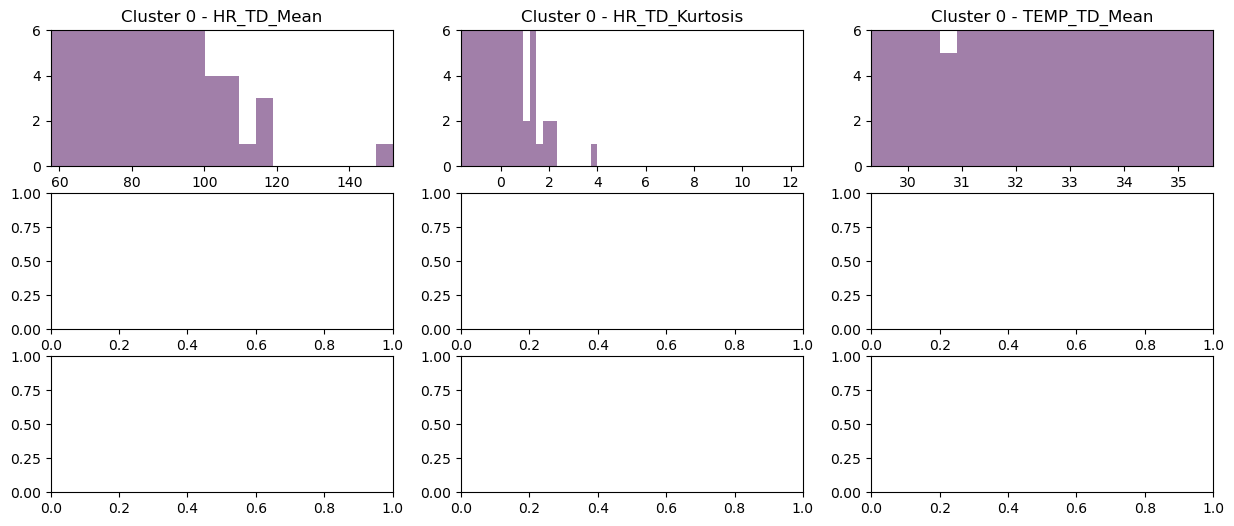

In [42]:
features = data_filtered.columns
# make a subplot with rows for each cluster and columns for each feature in data_filtered and show a histogram of the values in each cluster
fig, axs = plt.subplots(3, int(len(features)/2), figsize=(15, 6))

# across all clusters, calculate min and max of each feature
min = []
max = []
for feature in features:
    min.append(data[feature].min())
    max.append(data[feature].max())

max_count = [6, 50, 45]


# Get unique clusters
unique_clusters = sorted(data.cluster.unique())

# Set colormap
colors = plt.cm.get_cmap('viridis', len(unique_clusters))


for i in range(3):
    for j, feature in enumerate(features[:4]):
        # make histogram and color by cluster
        axs[i, j].hist(data[data['cluster'] == i][feature], bins=20, color=colors(i), alpha=0.5)
        axs[i, j].set_title(f'Cluster {i} - {feature}')
        axs[i,j].set_xlim(min[j], max[j])
        axs[i,j].set_ylim(0, max_count[i])

plt.tight_layout()
plt.show()



/var/folders/ng/ppmp_v5s0k51l14sqbjms5x40000gn/T/ipykernel_86483/1238737609.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_clusters))


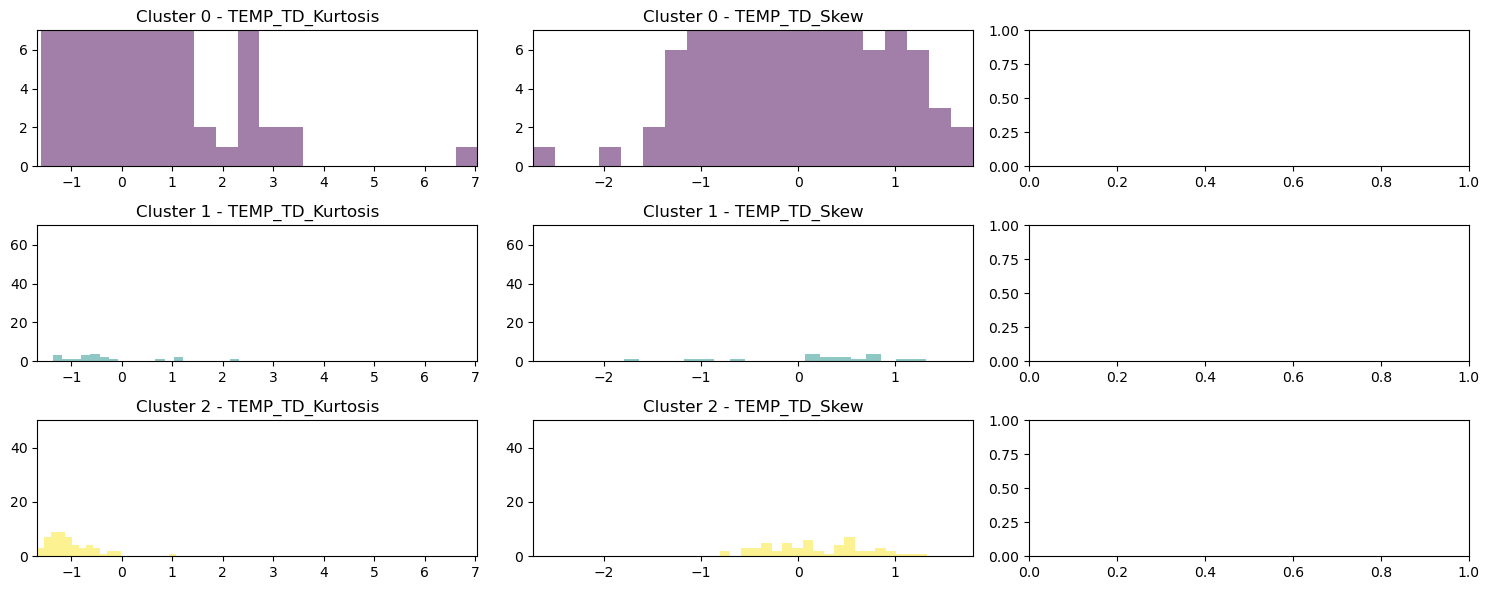

In [43]:
features = data_filtered.columns
# make a subplot with rows for each cluster and columns for each feature in data_filtered and show a histogram of the values in each cluster
fig, axs = plt.subplots(3, int(len(features)/2), figsize=(15, 6))

# across all clusters, calculate min and max of each feature
min = []
max = []
for feature in features[4:]:
    min.append(data[feature].min())
    max.append(data[feature].max())

max_count = [7, 70, 50]


# Get unique clusters
unique_clusters = sorted(data.cluster.unique())

# Set colormap
colors = plt.cm.get_cmap('viridis', len(unique_clusters))


for i in range(3):
    for j, feature in enumerate(features[4:]):
        # make histogram and color by cluster
        axs[i, j].hist(data[data['cluster'] == i][feature], bins=20, color=colors(i), alpha=0.5)
        axs[i, j].set_title(f'Cluster {i} - {feature}')
        axs[i,j].set_xlim(min[j], max[j])
        axs[i,j].set_ylim(0, max_count[i])

plt.tight_layout()
plt.show()

<Axes: ylabel='Frequency'>

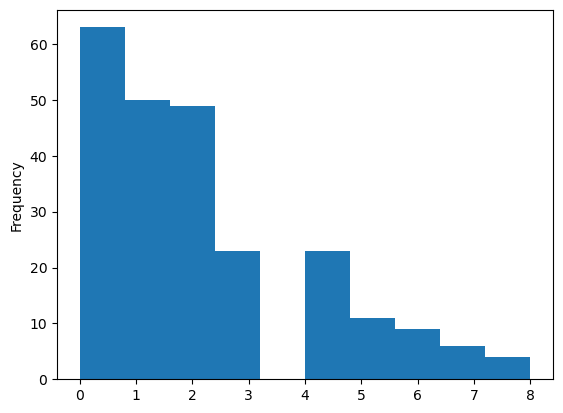

In [44]:
data[data['cluster'] == 0].Frustrated.plot.hist()

<Axes: ylabel='Frequency'>

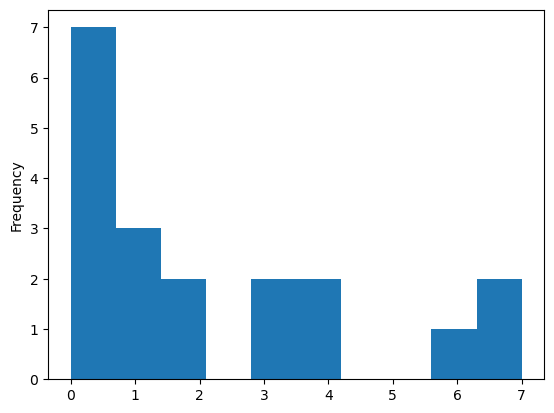

In [45]:
data[data['cluster'] == 1].Frustrated.plot.hist()

<Axes: ylabel='Frequency'>

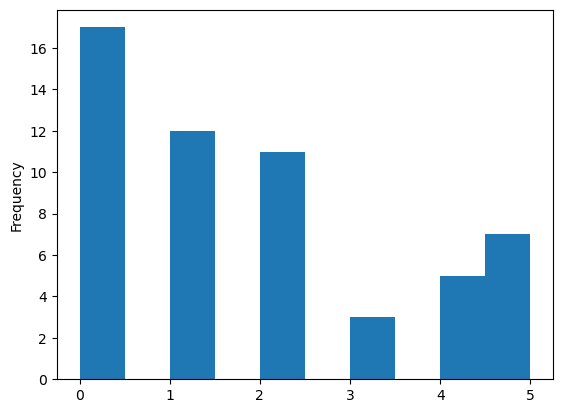

In [46]:
data[data['cluster'] == 2].Frustrated.plot.hist()

## PCA

In [8]:
from sklearn.preprocessing import LabelEncoder
# Function to convert string columns to numerical
def convert_strings_to_numerical(df):
    label_encoders = {}  # To store label encoder for each string column
    for column in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        # Fitting label encoder on the data
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le
    return df, label_encoders

# Convert string columns to numerical and get the updated DataFrame
data_encoded, encoders = convert_strings_to_numerical(data)

In [9]:
from sklearn.decomposition import PCA
pca3d = PCA(3)  # project from 64 to 2 dimensions
projected3d = pca3d.fit_transform(data_encoded)
print(data_encoded.shape)
print(projected3d.shape)

(312, 70)
(312, 3)


In [11]:
target3d = np.array(data_encoded['Phase'])

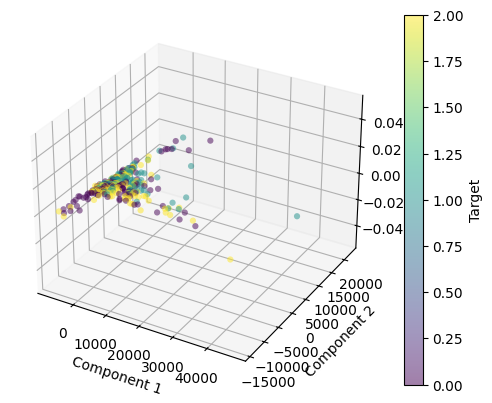

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming you have 'projected' (Nx2 array), 'target' (1D array), and 'plt' imported

# Create a new figure and axis with projection='3d'
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D
sc = ax.scatter(projected3d[:, 0], projected3d[:, 1], zs=0, zdir='z', c=target3d, edgecolor='none', alpha=0.5, cmap='viridis')

# Set labels and colorbar
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.colorbar(sc, label='Target')

plt.show()


In [13]:
from sklearn.decomposition import PCA
pca2d = PCA(2)  # project from 64 to 2 dimensions
projected2d = pca2d.fit_transform(data_encoded)
print(data_encoded.shape)
print(projected2d.shape)

(312, 70)
(312, 2)


In [14]:
target2d = np.array(data['Phase'])

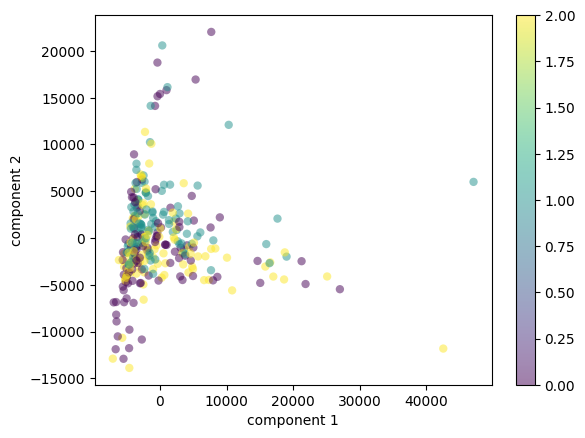

In [17]:
plt.scatter(projected2d[:, 0], projected2d[:, 1], c=target2d ,edgecolor='none', alpha=0.5,
            cmap=plt.colormaps['viridis'])
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

## PCA (numerical data) on Rounds and Phases

In [67]:
for i, round in enumerate(sorted(data.Round.unique())):
    for j, phase in enumerate(sorted(data.Phase.unique())):
        split = data[(data.Round == round) & (data.Phase == phase)]
        X = standardize(split[num_cols])
        pca2d = PCA(2)
        pca = pca2d.fit_transform(X)
        print()

array([2, 1, 0])

In [144]:
data['Cohort'] = data['Cohort'].replace([2, 3, 4, 5], 2)

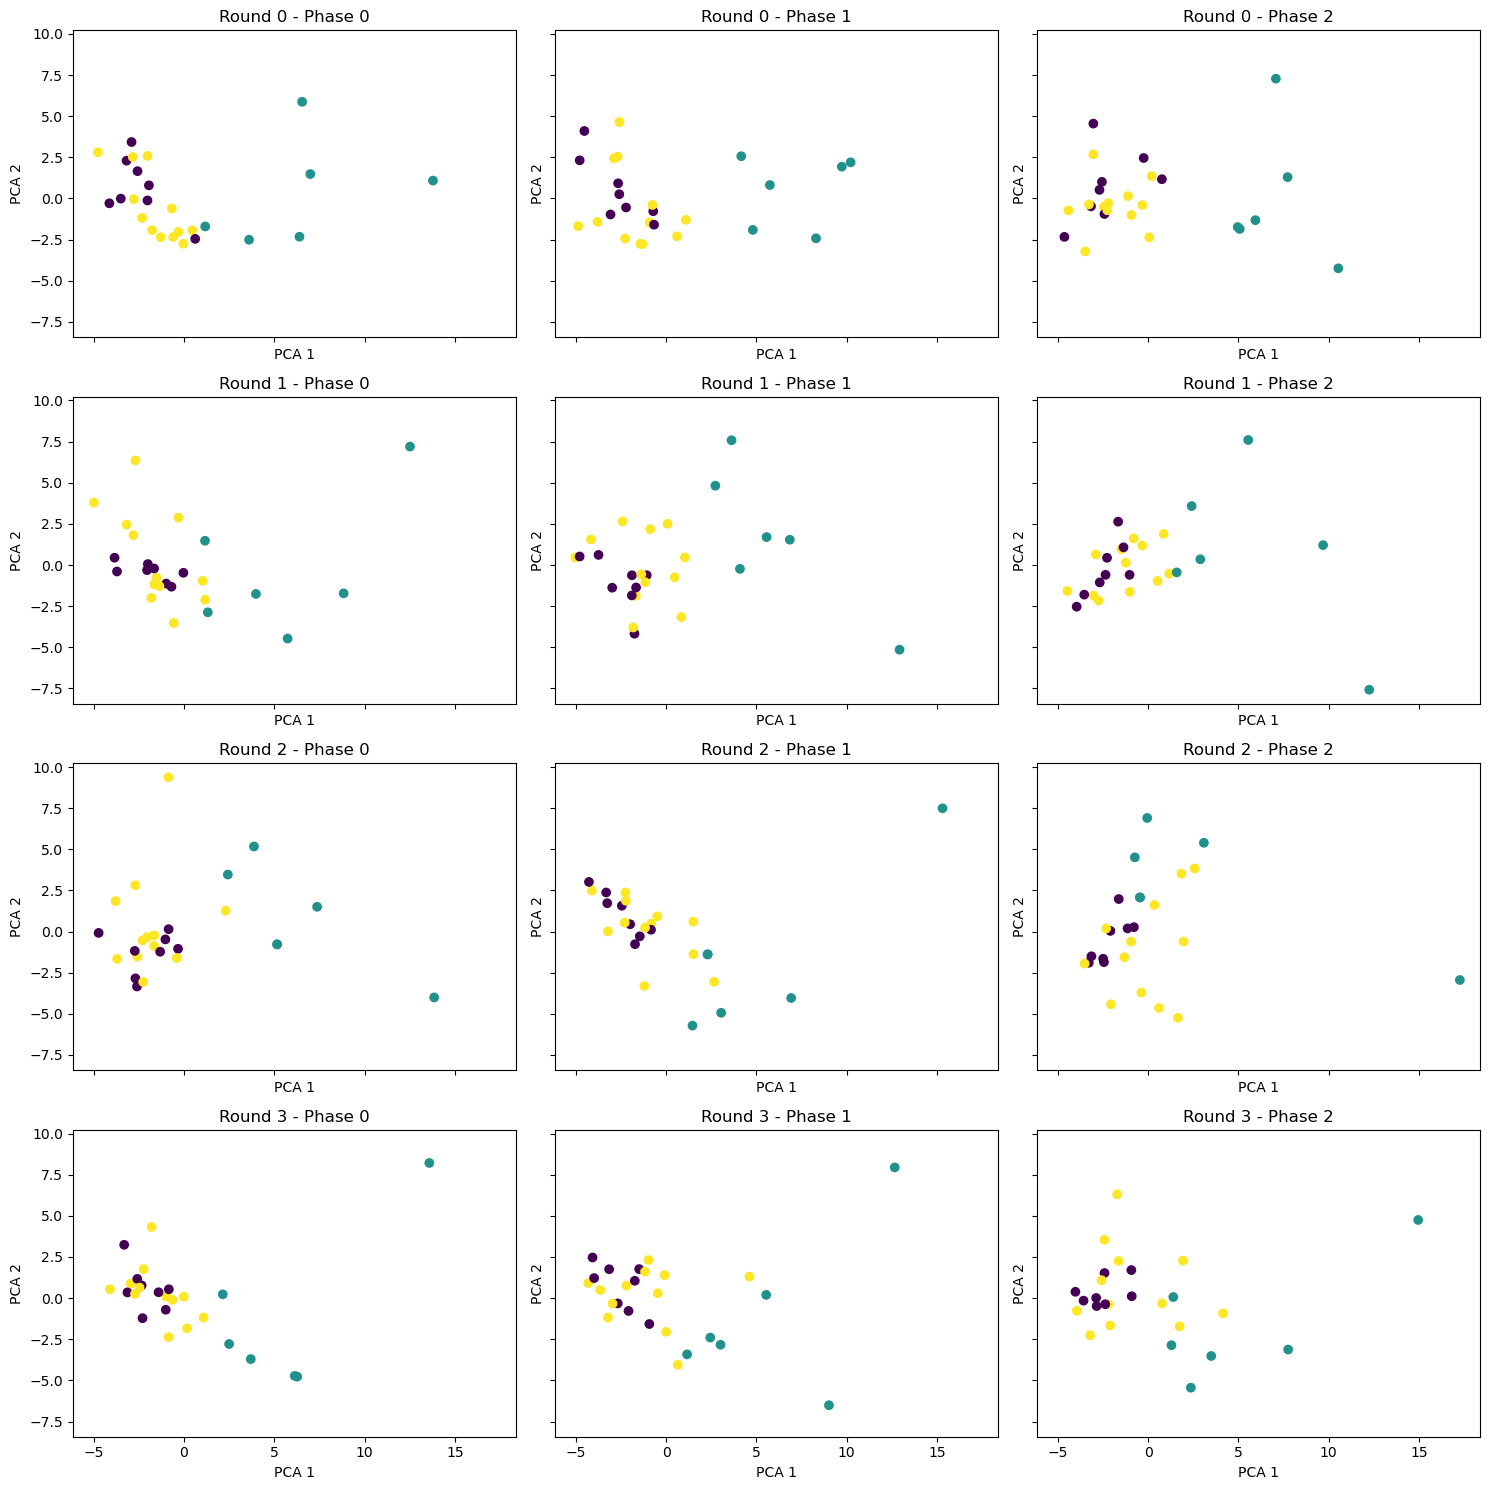

In [155]:
fig, axs = plt.subplots(4, 3, figsize=(15, 15), sharey=True, sharex=True)

for i, round in enumerate(sorted(data.Round.unique())):
    for j, phase in enumerate(sorted(data.Phase.unique())):
        split = data[(data.Round == round) & (data.Phase == phase)]
        X = standardize(split[num_cols])
        pca2d = PCA(2)
        pca = pca2d.fit_transform(X)
        axs[i, j].scatter(pca[:, 0], pca[:, 1], c=np.array(split['Cohort']))
        axs[i, j].set_title(f'Round {round} - Phase {phase}')
        axs[i, j].set_xlabel('PCA 1')
        axs[i, j].set_ylabel('PCA 2')

#axs[0, 0].legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()


In [41]:
data

,HR_TD_Mean,HR_TD_Median,HR_TD_std,HR_TD_Min,HR_TD_Max,HR_TD_AUC,HR_TD_Kurtosis,HR_TD_Skew,HR_TD_Slope_min,HR_TD_Slope_max,...,upset,hostile,alert,ashamed,inspired,nervous,attentive,afraid,active,determined
0,78.663878,76.700,7.480043,67.25,92.48,23048.450,-1.091448,0.369955,-0.730000,0.9775,...,1.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,2.0,2.0
1,76.540732,76.610,2.584756,69.82,82.33,23959.920,-0.245338,0.338732,-0.360000,0.1900,...,2.0,1.0,3.0,2.0,2.0,2.0,3.0,1.0,3.0,3.0
2,78.173563,77.920,2.681255,72.22,82.80,20324.605,-0.615922,-0.233047,-0.630000,0.3575,...,1.0,1.0,2.0,1.0,3.0,2.0,3.0,2.0,3.0,3.0
3,83.073688,83.880,7.363598,69.42,96.12,24924.300,-0.866610,-0.046021,-0.465000,0.6500,...,1.0,1.0,2.0,1.0,3.0,2.0,3.0,2.0,3.0,3.0
4,72.281250,72.910,3.193762,64.95,79.98,23052.100,0.200401,-0.560948,-0.372500,0.3375,...,3.0,1.0,3.0,2.0,3.0,3.0,4.0,2.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,82.019065,78.830,8.794206,69.73,97.18,26244.705,-1.386324,0.251382,-0.517500,0.3525,...,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0
308,103.274248,104.625,14.208117,68.13,125.52,31523.695,-0.338091,-0.521254,-0.962500,1.0875,...,2.0,1.0,3.0,1.0,1.0,1.0,4.0,1.0,3.0,4.0
309,99.065000,97.490,10.079197,86.55,119.75,28235.230,-0.740136,0.629730,-0.657500,0.9175,...,1.0,1.0,3.0,1.0,3.0,1.0,3.0,1.0,3.0,4.0
310,91.793354,97.180,19.234169,60.90,120.67,28909.835,-1.229115,-0.181431,-0.717500,0.9800,...,2.0,1.0,3.0,1.0,3.0,1.0,4.0,1.0,4.0,4.0


In [46]:
df

,HR_TD_Mean,HR_TD_Median,HR_TD_std,HR_TD_Min,HR_TD_Max,HR_TD_AUC,HR_TD_Kurtosis,HR_TD_Skew,HR_TD_Slope_min,HR_TD_Slope_max,...,EDA_TD_T_AUC,EDA_TD_T_Kurtosis,EDA_TD_T_Skew,EDA_TD_T_Slope_min,EDA_TD_T_Slope_max,EDA_TD_T_Slope_mean,EDA_TD_T_Slope,EDA_TD_P_Peaks,EDA_TD_P_RT,EDA_TD_P_ReT
0,0.010007,-0.062252,0.186914,-0.163617,0.001626,-0.312025,-0.620396,-0.007311,-0.414192,0.976552,...,-0.673544,0.275974,-1.308661,0.594771,-0.666215,0.135760,0.096504,-1.011367,1.125607,0.097078
1,-0.176517,-0.069694,-0.792361,0.111511,-0.569893,-0.086150,-0.114098,-0.045208,0.531521,-0.698825,...,-0.673565,0.135858,0.943874,0.594722,-0.665524,0.134970,0.094853,-0.688227,0.461322,0.287495
2,-0.033069,0.038626,-0.773057,0.368440,-0.543429,-0.987033,-0.335849,-0.739221,-0.158594,-0.342475,...,-0.679611,-0.072091,0.567205,0.595373,-0.666366,0.130436,0.091164,-1.092152,-0.060007,0.155694
3,0.397420,0.531440,0.163620,0.068689,0.206585,0.152837,-0.485856,-0.512212,0.263143,0.279808,...,-0.676802,0.624699,1.339819,0.588825,-0.657510,0.128842,0.089956,-0.930582,-0.244919,-0.340292
4,-0.550724,-0.375636,-0.670533,-0.409841,-0.702215,-0.311121,0.152625,-1.137219,0.499571,-0.385024,...,-0.676742,0.230339,1.688196,0.589497,-0.661233,0.137879,0.097946,-0.284301,-0.403998,-0.144019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,0.304769,0.113871,0.449805,0.101876,0.266270,0.480053,-0.796844,-0.151232,0.128954,-0.353112,...,-0.474853,-0.082622,1.210638,0.264703,0.013854,0.762031,0.733633,-0.122731,-0.367287,-0.543195
308,2.172093,2.246782,1.532829,-0.069410,1.862020,1.788262,-0.169600,-1.089040,-1.008457,1.210573,...,-0.482926,-0.106971,0.988142,0.468316,-0.351494,0.241524,0.201502,0.119624,-0.314261,-0.280963
309,1.802300,1.656811,0.706861,1.902519,1.537126,0.973334,-0.410176,0.307998,-0.228883,0.848905,...,-0.361328,-0.379840,0.206587,0.261302,-0.171246,-0.100906,-0.078833,-0.688227,0.215186,0.439115
310,1.163466,1.631178,2.538264,-0.843408,1.588929,1.140510,-0.702773,-0.676571,-0.382242,0.981871,...,-0.462706,-0.496055,0.677125,0.407151,-0.176961,1.043382,1.013743,1.573755,-0.726424,-0.557285


/var/folders/bc/ynvgg9rn14v5sl_jcp8x8_s40000gn/T/ipykernel_13719/980630945.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='PC1', y='PC2', data=principal_df, palette='Set2', s=50, alpha=0.8, edgecolor='w', ax=ax)


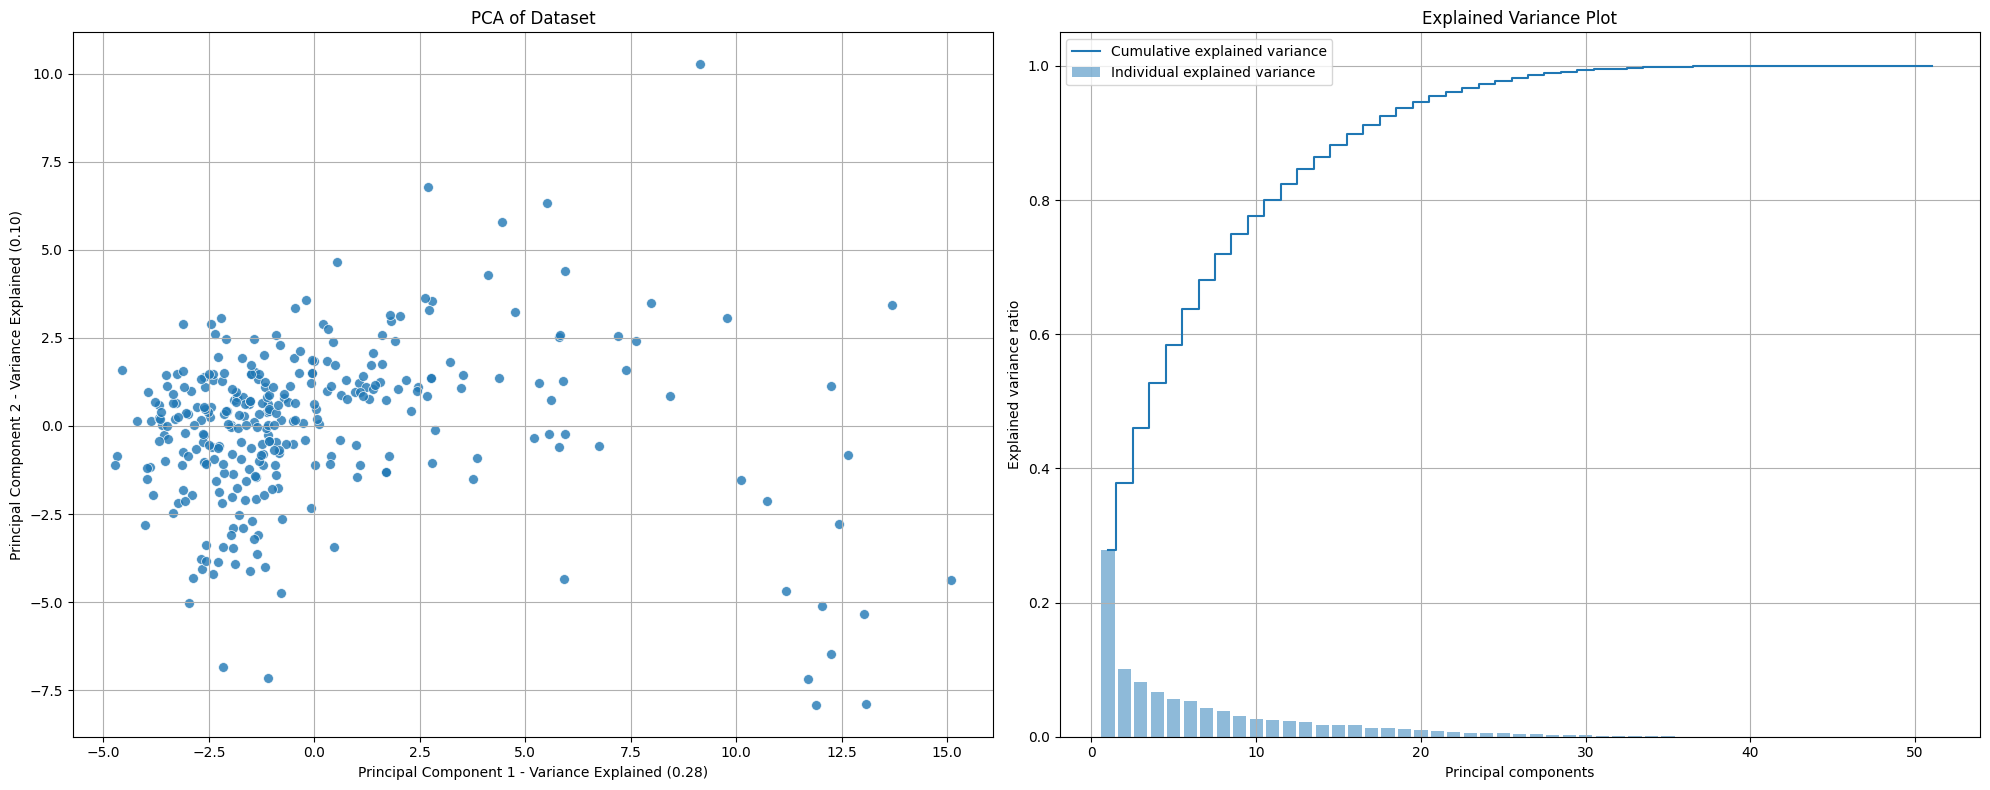

In [47]:
from sklearn.decomposition import PCA
df = standardize(data[num_cols])
# PCA
pca = PCA()  # Reduce to 2 dimensions for visualization
principal_components = pca.fit_transform(df[num_cols])
principal_df = pd.DataFrame(data=principal_components[:,[0,1]], columns=['PC1', 'PC2'])
principal_top_25 = pd.DataFrame(data=principal_components[:,[:25]], columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25']])
# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Plotting
fig, axs = plt.subplots(1, 2,figsize=(20, 8))
ax = axs[0]
sns.scatterplot(x='PC1', y='PC2', data=principal_df, palette='Set2', s=50, alpha=0.8, edgecolor='w', ax=ax)
ax.set_title('PCA of Dataset')
ax.set_xlabel(f'Principal Component 1 - Variance Explained ({explained_variance[0]:.2f})')
ax.set_ylabel(f'Principal Component 2 - Variance Explained ({explained_variance[1]:.2f})')
ax.grid(True)

# Cumulative explained variance
cumulative_variance = explained_variance.cumsum()
ax = axs[1]
# Plotting
ax.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
ax.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative explained variance')
ax.set_ylabel('Explained variance ratio')
ax.set_xlabel('Principal components')
ax.set_title('Explained Variance Plot')
ax.legend(loc='best')
ax.grid(True)


plt.tight_layout()
plt.show()

In [68]:
principal_components[:, [0,1,2,3,4,5,6,7,8,9,10]]

array([[-3.14915348, -1.10793282, -2.03080152, ..., -0.62520531,
        -0.4758619 , -0.76595121],
       [-3.29339274,  0.20893921, -0.89382838, ...,  0.55948411,
        -0.22042045, -0.21210222],
       [-3.87348106,  0.13843316, -1.56997495, ...,  0.19228517,
         0.31008711,  0.21418225],
       ...,
       [-2.17175034, -3.42305586,  0.71350221, ...,  0.03040753,
         0.30959493, -0.18997456],
       [-1.16645398, -3.99047906,  0.52474404, ..., -0.17909653,
        -0.08382815,  0.98021084],
       [-3.06601358, -2.12316245,  0.97621386, ..., -0.19545097,
         0.58249493,  0.48673182]])

In [76]:
principal_top_25 = pd.DataFrame(data=principal_components[:, [0,1,2,3,4,5,6,7,8,9]], columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])
principal_top_25

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-3.149153,-1.107933,-2.030802,-1.160852,-0.078287,-2.106494,1.827742,1.736819,2.263000,-0.262957
1,-3.293393,0.208939,-0.893828,0.225156,0.126936,1.092629,0.899917,-1.259613,-0.328296,-0.308917
2,-3.873481,0.138433,-1.569975,-0.178093,-0.302753,-0.674682,1.759689,-1.421042,-0.547040,0.193756
3,-3.547996,-0.987135,0.717444,1.363025,1.232325,3.558451,3.172072,-0.038606,-0.895289,1.089190
4,-3.603219,0.039350,-2.313881,-1.347648,0.593589,-0.163861,0.634696,-1.033751,-0.196397,0.013383
...,...,...,...,...,...,...,...,...,...,...
307,-0.913921,-1.395007,-0.746302,-1.458501,1.240932,-0.305117,-0.153847,-0.664148,-0.472546,-0.584032
308,-1.892893,-3.918833,1.786215,-1.483339,0.364966,0.205940,1.681085,0.502672,-0.576422,0.915372
309,-2.171750,-3.423056,0.713502,-0.334238,0.299240,-0.585097,2.862509,-1.293539,0.002057,0.188084
310,-1.166454,-3.990479,0.524744,-1.635144,2.644712,-0.906537,0.071175,0.305785,0.326530,0.037632


In [77]:
# Kmeans
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(principal_top_25)
data['cluster'] = kmeans.labels_

In [78]:
data['cluster'].value_counts()

cluster
1    240
0     59
2     13
Name: count, dtype: int64

/var/folders/bc/ynvgg9rn14v5sl_jcp8x8_s40000gn/T/ipykernel_13719/320377520.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_clusters))


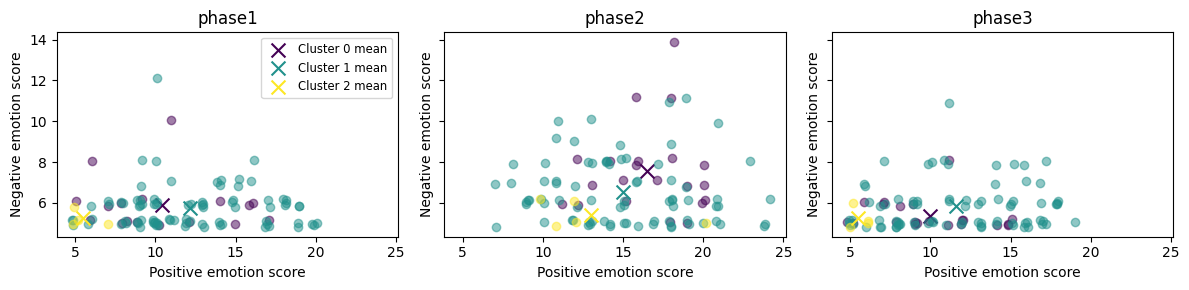

In [82]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharey=True, sharex=True)

# Get unique rounds and phases
unique_phases = sorted(data.Phase.unique())

# Get unique clusters
unique_clusters = sorted(data.cluster.unique())

# Set colormap
colors = plt.cm.get_cmap('viridis', len(unique_clusters))

# Set size based on Cohort
# Merge Cohort D1_3, D1_4, D1_5 and D1_6 into D1_3
data['Cohort'] = data['Cohort'].apply(lambda x: 'D1_3' if x in ['D1_4', 'D1_5', 'D1_6'] else x)
# Cohort value, 5, 10 or 15
data['Cohort_value'] = ((data['Cohort'].apply(lambda x: int(x.split('_')[1])))+1)*25


# Iterate over rounds and phases
for j, phase in enumerate(unique_phases):
    split = data[(data.Phase == phase)]
    
    # Scatter plot with color by cluster
    for cluster, color in zip(unique_clusters, colors.colors):
        cluster_data = split[split.cluster == cluster]

        # Calculate the mean of the cluster for the positive and negative emotions
        mean_positive = cluster_data.positive_score.mean()
        mean_negative = cluster_data.negative_score.mean()

        axs[j].scatter(jitter_points(cluster_data.positive_score), 
                            jitter_points(cluster_data.negative_score),
                            color=color, alpha=0.5)
        
        # Plot the mean of the cluster
        axs[j].scatter(mean_positive, mean_negative, color=color, marker='x', s=100, label=f'Cluster {cluster} mean' if (j == 0) else None)
    
    axs[j].set_title(f'{phase}')
    axs[j].set_xlabel('Positive emotion score')
    axs[j].set_ylabel('Negative emotion score')

# Legend only for the first subplot
axs[0].legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()